In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import os
from ctypes import c_int, c_double, POINTER, cdll
from tqdm import tqdm

In [2]:
# Release dll if loaded
dll = None
# Compile cuda code and load dll
os.system("pwsh ./run.ps1 > log")
dll = cdll.LoadLibrary("./build/Release/kernel.dll")
## Define function signatures
# void call_qpe_kernel(double* data, int nAll, int T, int R, bool unbiased)
dll.call_qpe_kernel.argtypes = [POINTER(c_double), c_int, c_int, c_int, c_int]
# void call_mlae_kernel(double* data, int nAll, int length, int* Ms, int* Rs)
dll.call_mlae_kernel.argtypes = [POINTER(c_double), c_int, c_int, POINTER(c_int), POINTER(c_int)]
# void call_rqae_kernel(double* data, int nAll, int T, int R)
dll.call_rqae_kernel.argtypes = [POINTER(c_double), c_int, c_int, c_int]
# void call_oqae_kernel(double* data, int nAll, int T)
dll.call_oqae_kernel.argtypes = [POINTER(c_double), c_int, c_int]

In [3]:
nSample = 10000
stats = {}

Standard QPE - Four Shot

In [17]:
stat_QPE = []
for T in 1 << np.arange(7, 14):
    src = np.random.random(nSample)
    res = np.copy(src)
    dll.call_qpe_kernel(res.ctypes.data_as(POINTER(c_double)), nSample, T//4, 4, 0)
    stat_QPE.append([(T-1)*2, la.norm(res-src)/np.sqrt(nSample)])
stats["QPE"] = stat_QPE
stat_QPE

[[254, 0.03137259380876302],
 [510, 0.013542540074471247],
 [1022, 0.0072868575369050455],
 [2046, 0.0033910782228922243],
 [4094, 0.0016064689824941028],
 [8190, 0.0008227834283403331],
 [16382, 0.0004111945040892987]]

Unbiased QPE - Four Shot

In [5]:
stat_UQPE = []
for T in 1 << np.arange(7, 14):
    src = np.random.random(nSample)
    res = np.copy(src)
    dll.call_qpe_kernel(res.ctypes.data_as(POINTER(c_double)), nSample, T//4, 4, 1)
    stat_UQPE.append([(T-1)*2, la.norm(res-src)/np.sqrt(nSample)])
stats["UQPE"] = stat_UQPE
stat_UQPE

[[254, 0.020203697997677458],
 [510, 0.009326728817315723],
 [1022, 0.004940947643292269],
 [2046, 0.0023970559430693565],
 [4094, 0.0012635451859013525],
 [8190, 0.0005799926291043907],
 [16382, 0.00031033223410159105]]

MLAE - Fixing R=32

In [6]:
stat_MLAE = []
for T in tqdm(1 << np.arange(3, 10)):
    src = np.random.random(nSample)
    res = np.copy(src)
    length = int(T).bit_length() - 1
    Rs = np.array([          32 for i in range(length)], dtype=np.int32)
    Ms = np.array([(1 << i | 1) for i in range(length)], dtype=np.int32)
    dll.call_mlae_kernel(res.ctypes.data_as(POINTER(c_double)), nSample, length, Ms.ctypes.data_as(POINTER(c_int)), Rs.ctypes.data_as(POINTER(c_int)))
    stat_MLAE.append([(T-1)*32, la.norm(res-src)/np.sqrt(nSample)])
stats["MLAE"] = stat_MLAE
stat_MLAE

100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


[[224, 0.015832906863935226],
 [480, 0.009463941524332926],
 [992, 0.004420306855032335],
 [2016, 0.0024032770288413057],
 [4064, 0.0012413065650523692],
 [8160, 0.0009410719869412601],
 [16352, 0.00034562016084280293]]

RQAE - Fixing R=12

In [7]:
stat_RQAE = []
for T in tqdm(1 << np.arange(4, 11)):
    src = np.random.random(nSample)
    res = np.copy(src)
    dll.call_rqae_kernel(res.ctypes.data_as(POINTER(c_double)), nSample, T, 12)
    stat_RQAE.append([(T-1)*12, la.norm(res-src)/np.sqrt(nSample)])
stats["RQAE"] = stat_RQAE
stat_RQAE

100%|██████████| 7/7 [00:33<00:00,  4.79s/it]


[[180, 0.010422395817995507],
 [372, 0.005236485679609119],
 [756, 0.002696818497796807],
 [1524, 0.0012788613427516613],
 [3060, 0.0006144186642933349],
 [6132, 0.00030310933062590017],
 [12276, 0.00015357525915499687]]

Optimzied QAE

In [8]:
stat_OQAE = []
for T in 1 << np.arange(7, 14):
    src = np.random.random(nSample)
    res = np.copy(src)
    dll.call_oqae_kernel(res.ctypes.data_as(POINTER(c_double)), nSample, T)
    stat_OQAE.append([(T-1)*2, la.norm(res-src)/np.sqrt(nSample)])
stats["OQAE"] = stat_OQAE
stat_OQAE

[[254, 0.009929034562177844],
 [510, 0.004950457870002516],
 [1022, 0.002436220499432016],
 [2046, 0.0012524699088414268],
 [4094, 0.000605757248821186],
 [8190, 0.00031243857714530356],
 [16382, 0.00015820391098120715]]

Plot $N$ - $N\cdot\epsilon$

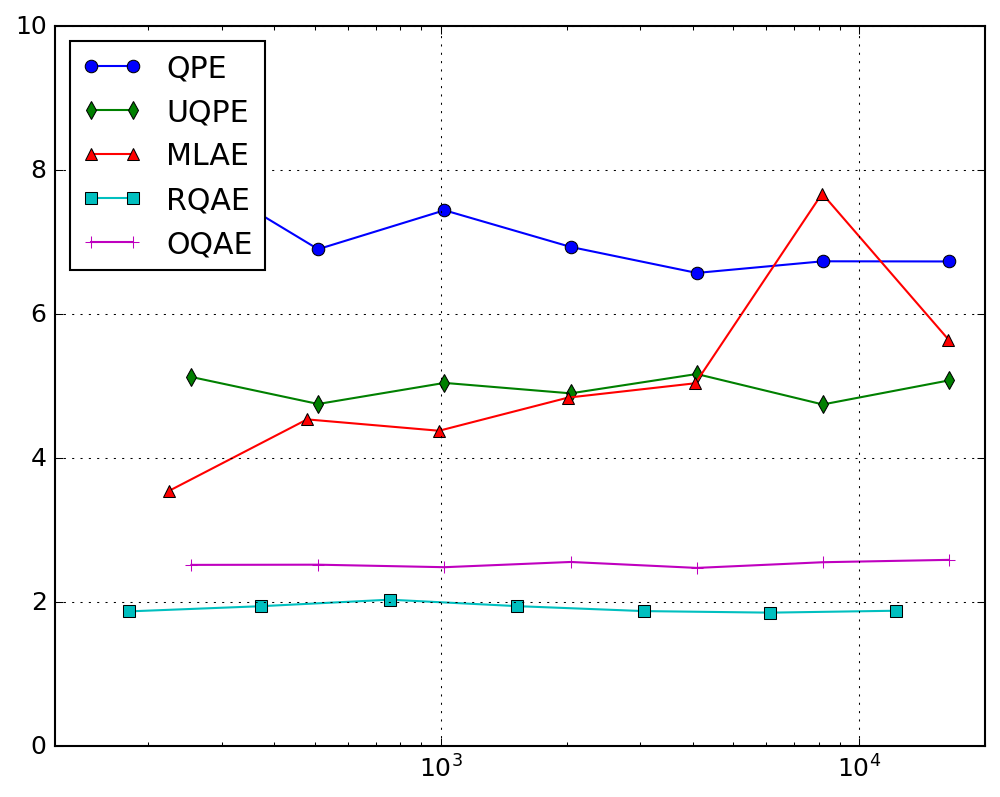

In [18]:
plt.style.use("classic")
plt.figure(dpi=150)
for idx, key in enumerate(stats):
    T, err = np.array(stats[key]).T
    plt.plot(T, T*err, label=key, marker="od^s+h"[idx])
plt.xscale("log")
plt.xlim(120, 20000)
plt.ylim(0, 10)
plt.grid(True)
plt.legend(loc="upper left")
plt.gcf().set_facecolor("white")
plt.show()